# Intro<br>
This file has the different clustering approaches applied to Ishi data to cluster journal documents (JD)
<ol>
    <li><b>K means on full population based on One hot encoded GL_AccType_AccountTypeDesc and Dr_Cr:</b><br> Let K means algorithm figure out how to cluster JDs based on the type of transactions with each unique acccount type present in the JD</li>
    <li><b>Manual clustering:</b><br> Cluster based on unique combinations of transaction to the different account types present in the JD</li>
</ol>

# Set up

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from importlib import reload
import pandas as pd

# sys.path.append(r"E:\enyutan\Document\2025 MJE Advanced Analytics\Ishi")
import _00_util_sql
reload(_00_util_sql)
from _00_util_sql import Conn_ODBC

In [2]:
# Import packages
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

In [3]:
##### Import data 
sql_db=Conn_ODBC(database="JE_ML_2025")
conn=sql_db.odbc_conn_db_pyodbc()
sql_query=f"SELECT * FROM [data_p_ishi_GL_JE_cleaned_2019] WHERE AccDocNo LIKE '99%'"
sales_data=sql_db.odbc_run_sql(conn, sql_query, return_result=True)
conn.close()

sales_data.head(5)
# 1-2 mins

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Liability - G\L Account,Dr_Liability - Vendor,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id
0,2019,9911456081,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:37,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[905.0, -905.0, -802.87, 802.87]",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
1,2019,9911456082,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:38,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1860.0, -1860.0, -1736.22, 1736.22]",Billing Doc.Transfer,"[0.0, 40.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
2,2019,9911456340,"[Dr, Cr, Cr, Cr, Cr]",2019-01-15,2019-01-16 12:47:22,"[001, 002, 003, 004, 005]","[Accounts Receivable Control Account, Third Pa...","[316.0, -79.0, -79.0, -79.0, -79.0]",Billing Doc.Transfer,"[0.0, 1.0, 1.0, 1.0, 1.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
3,2019,9911456098,"[Dr, Cr, Cr, Dr]",2019-01-25,2019-01-25 20:00:33,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1122.0, -1122.0, -1006.08, 1006.08]",Billing Doc.Transfer,"[0.0, 11.0, 0.0, 0.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None
4,2019,9911456169,"[Dr, Cr]",2019-01-17,2019-01-17 16:10:08,"[001, 002]","[Accounts Receivable Control Account, Third Pa...","[1325.0, -1325.0]",Billing Doc.Transfer,"[0.0, 5.0]",...,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None


In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 77 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

# K Means on full population using One hot encoded GL_AccType_AccountTypeDesc and Dr_Cr

In [5]:
features = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [6]:
X = sales_data.copy()
X[features] = (X[features] != 0).astype(int)
X[features].head(5)

,Cr_Asset - Asset,Cr_Asset - Customer,Cr_Asset - G\L Account,Cr_Asset - Material,Cr_Cost of Goods Sold (COGS) - G\L Account,Cr_Expense (6) - G\L Account,Cr_Liability - G\L Account,Cr_Liability - Vendor,Cr_Other Costs - G\L Account,Cr_Other Revenue - G\L Account,...,Dr_Asset - Customer,Dr_Asset - G\L Account,Dr_Asset - Material,Dr_Cost of Goods Sold (COGS) - G\L Account,Dr_Expense (6) - G\L Account,Dr_Liability - G\L Account,Dr_Liability - Vendor,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


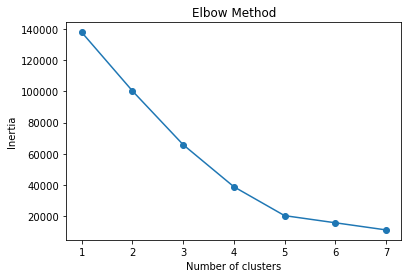

In [7]:
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X[features])
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [15]:
# Cluster
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X[features])

# Get cluster centers (Coordinates of cluster centers)
centers = kmeans.cluster_centers_

# Get each point's cluster assignment (Labels of each point)
labels = kmeans.labels_ 

distances = np.linalg.norm(X[features] - centers[labels], axis=1)  # euclidean distance

In [16]:
sales_data['K_cluster'] = labels
sales_data.head(5)

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Cluster_Signature,Cluster_ID,K_cluster
0,2019,9911456081,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:37,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[905.0, -905.0, -802.87, 802.87]",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0]",...,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43,2
1,2019,9911456082,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:38,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1860.0, -1860.0, -1736.22, 1736.22]",Billing Doc.Transfer,"[0.0, 40.0, 0.0, 0.0]",...,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43,2
2,2019,9911456340,"[Dr, Cr, Cr, Cr, Cr]",2019-01-15,2019-01-16 12:47:22,"[001, 002, 003, 004, 005]","[Accounts Receivable Control Account, Third Pa...","[316.0, -79.0, -79.0, -79.0, -79.0]",Billing Doc.Transfer,"[0.0, 1.0, 1.0, 1.0, 1.0]",...,0.0,0.0,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Asset - Customer",64,0
3,2019,9911456098,"[Dr, Cr, Cr, Dr]",2019-01-25,2019-01-25 20:00:33,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1122.0, -1122.0, -1006.08, 1006.08]",Billing Doc.Transfer,"[0.0, 11.0, 0.0, 0.0]",...,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43,2
4,2019,9911456169,"[Dr, Cr]",2019-01-17,2019-01-17 16:10:08,"[001, 002]","[Accounts Receivable Control Account, Third Pa...","[1325.0, -1325.0]",Billing Doc.Transfer,"[0.0, 5.0]",...,0.0,0.0,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Asset - Customer",64,0


In [18]:
sales_data['K_cluster'].value_counts()

0    101479
1     20383
2     19810
3      9696
4      5372
Name: K_cluster, dtype: int64

In [19]:
# Save results
table_name="cluster_22_clustered"

sql_db.fn_create_new_table_from_df(table_name=table_name, df=sales_data, auto_data_type=True)
res=sql_db.fn_append_df_to_table(table_name=table_name, df=sales_data)
print(res)

# 8 mins

True


## Feature importance

In [20]:
from sklearn.ensemble import RandomForestClassifier
# On new results
# Train a classifier to predict clusters (surrogate model)
df = X[features].copy()
df['cluster'] = kmeans.fit_predict(df)

# Train surrogate model
X = df.drop('cluster', axis=1)
y = df['cluster']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Extract feature importances
importances = clf.feature_importances_
# feature_names = df.columns[:-1]  # exclude 'cluster' column
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances,
    'Importance (%)': importances * 100
})
# .sort_values(by='Importance', ascending=False)

In [21]:
feature_importance_df
# .sort_values(by='Importance', ascending=False)

,Feature,Importance,Importance (%)
0,Cr_Asset - Asset,0.000000,0.000000
1,Cr_Asset - Customer,0.072593,7.259338
2,Cr_Asset - G\L Account,0.212178,21.217770
3,Cr_Asset - Material,0.000000,0.000000
4,Cr_Cost of Goods Sold (COGS) - G\L Account,0.201780,20.177974
5,Cr_Expense (6) - G\L Account,0.000000,0.000000
6,Cr_Liability - G\L Account,0.003261,0.326087
7,Cr_Liability - Vendor,0.000000,0.000000
8,Cr_Other Costs - G\L Account,0.000465,0.046540
9,Cr_Other Revenue - G\L Account,0.033990,3.399040


# Manual clustering <br>
Based on GL_AccType_AccountTypeDesc and Dr_Cr

In [5]:
features = [
'Cr_Asset - Asset',
'Cr_Asset - Customer', 
'Cr_Asset - G\\L Account', 
'Cr_Asset - Material',
'Cr_Cost of Goods Sold (COGS) - G\\L Account',
'Cr_Expense (6) - G\\L Account',
'Cr_Liability - G\\L Account', 
'Cr_Liability - Vendor',
'Cr_Other Costs - G\\L Account', 
'Cr_Other Revenue - G\\L Account', 
'Cr_Revenue - G\\L Account', 
'Dr_Asset - Asset', 
'Dr_Asset - Customer', 
'Dr_Asset - G\\L Account', 
'Dr_Asset - Material', 
'Dr_Cost of Goods Sold (COGS) - G\\L Account', 
'Dr_Expense (6) - G\\L Account', 
'Dr_Liability - G\\L Account', 
'Dr_Liability - Vendor', 
'Dr_Other Costs - G\\L Account', 
'Dr_Other Revenue - G\\L Account', 
'Dr_Revenue - G\\L Account'
]

In [6]:
# Create a signature string for each row
sales_data['Cluster_Signature'] = sales_data[features].apply(
    lambda row: ', '.join([col for col, val in row.items() if val != 0]), axis=1
)
# axis=1 applied lambda function row-wise
# lambda function finds the columns where values != 0 and joins them with ', '

# Now group by the signature to form clusters
clusters = sales_data.groupby('Cluster_Signature')

sales_data['Cluster_ID'] = sales_data.groupby('Cluster_Signature').ngroup()

In [7]:
sales_data.head(5)

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Cluster_Signature,Cluster_ID
0,2019,9911456081,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:37,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[905.0, -905.0, -802.87, 802.87]",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0]",...,0.0,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43
1,2019,9911456082,"[Dr, Cr, Cr, Dr]",2019-01-15,2019-01-16 12:32:38,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1860.0, -1860.0, -1736.22, 1736.22]",Billing Doc.Transfer,"[0.0, 40.0, 0.0, 0.0]",...,0.0,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43
2,2019,9911456340,"[Dr, Cr, Cr, Cr, Cr]",2019-01-15,2019-01-16 12:47:22,"[001, 002, 003, 004, 005]","[Accounts Receivable Control Account, Third Pa...","[316.0, -79.0, -79.0, -79.0, -79.0]",Billing Doc.Transfer,"[0.0, 1.0, 1.0, 1.0, 1.0]",...,0.0,0.0,0.0,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Asset - Customer",64
3,2019,9911456098,"[Dr, Cr, Cr, Dr]",2019-01-25,2019-01-25 20:00:33,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[1122.0, -1122.0, -1006.08, 1006.08]",Billing Doc.Transfer,"[0.0, 11.0, 0.0, 0.0]",...,0.0,0.0,0.0,None,None,None,None,None,"Cr_Asset - G\L Account, Cr_Revenue - G\L Accou...",43
4,2019,9911456169,"[Dr, Cr]",2019-01-17,2019-01-17 16:10:08,"[001, 002]","[Accounts Receivable Control Account, Third Pa...","[1325.0, -1325.0]",Billing Doc.Transfer,"[0.0, 5.0]",...,0.0,0.0,0.0,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Asset - Customer",64


In [8]:
# Number of combinations
# print(sales_data['Cluster_Signature'].nunique())

# List of combinations
# sales_data['Cluster_Signature'].unique().tolist()

# sales_data['Cluster_ID'].value_counts().sort_index()
# sort_index() re-sorts that Series by the index (Cluster_ID)

In [9]:
# Get cluster signature, cluster id and population map
cluster_id_to_signature = sales_data.copy()
cluster_id_to_signature = cluster_id_to_signature[['Cluster_ID', 'Cluster_Signature']].drop_duplicates()

cluster_counts = sales_data['Cluster_ID'].value_counts().sort_index()
cluster_id_to_signature['Population'] = cluster_id_to_signature['Cluster_ID'].map(cluster_counts)

cluster_map = dict(zip(cluster_id_to_signature['Cluster_ID'], 
                       zip(cluster_id_to_signature['Cluster_Signature'],
                       cluster_id_to_signature['Population'])))

cluster_map

{43: ('Cr_Asset - G\\L Account, Cr_Revenue - G\\L Account, Dr_Asset - Customer, Dr_Cost of Goods Sold (COGS) - G\\L Account',
  18885),
 64: ('Cr_Revenue - G\\L Account, Dr_Asset - Customer', 96233),
 50: ('Cr_Cost of Goods Sold (COGS) - G\\L Account, Cr_Revenue - G\\L Account, Dr_Asset - Customer, Dr_Liability - G\\L Account',
  16790),
 8: ('Cr_Asset - Customer, Cr_Cost of Goods Sold (COGS) - G\\L Account, Dr_Asset - G\\L Account, Dr_Revenue - G\\L Account',
  86),
 40: ('Cr_Asset - G\\L Account, Cr_Other Revenue - G\\L Account, Dr_Asset - Customer, Dr_Other Costs - G\\L Account',
  4461),
 65: ('Cr_Revenue - G\\L Account, Dr_Asset - Customer, Dr_Revenue - G\\L Account',
  4380),
 51: ('Cr_Cost of Goods Sold (COGS) - G\\L Account, Cr_Revenue - G\\L Account, Dr_Asset - Customer, Dr_Liability - G\\L Account, Dr_Revenue - G\\L Account',
  2903),
 6: ('Cr_Asset - Customer, Cr_Cost of Goods Sold (COGS) - G\\L Account, Cr_Revenue - G\\L Account, Dr_Asset - G\\L Account, Dr_Revenue - G\\L A

In [ ]:
# Convert cluster_map dictionary to a DataFrame
cluster_map_df = pd.DataFrame.from_dict(cluster_map, orient='index', columns=['Cluster_Signature', 'Population'])
cluster_map_df.index.name = 'Cluster_ID'
cluster_map_df = cluster_map_df.reset_index()  # Make Cluster_ID a column instead of index
cluster_map_df = cluster_map_df.sort_values(by='Population', ascending=False)
cluster_map_df

# Save to Excel
cluster_map_df.to_excel(rf"D:\victoriaquek\JE ML 2025\ManualCluster.xlsx", index=False)

# Save to sql
# table_name="Manual_cluster_profile"

# sql_db.fn_create_new_table_from_df(table_name=table_name, df=cluster_map_df, auto_data_type=True)
# res=sql_db.fn_append_df_to_table(table_name=table_name, df=cluster_map_df)
# print(res)

## K Means on small clusters

In [15]:
# small_cluster_data = sales_data[sales_data['Cluster_ID'].isin(small_cluster_ids)]
# small_cluster_data.info()

# OR 

# Step 1: Identify cluster IDs with fewer than 1000 rows
small_cluster_ids = sales_data['Cluster_ID'].value_counts()[lambda x: x < 1000].index
print(len(small_cluster_ids))
print(small_cluster_ids.sort_values())
# Step 2: Filter the DataFrame to only include rows from those small clusters
small_cluster_data = sales_data[sales_data['Cluster_ID'].isin(small_cluster_ids)].copy()

# small_cluster_data.info()

58
Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 41, 42, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 66],
      dtype='int64', name='Cluster_ID')


In [16]:
small_cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3995 entries, 12 to 156736
Data columns (total 79 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  3995 non-null   int64         
 1   AccDocNo                                    3995 non-null   int64         
 2   Dr_Cr                                       3995 non-null   object        
 3   DateOfAccDocEntry                           3995 non-null   object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     3995 non-null   datetime64[ns]
 5   NoOfLineItemInAccDoc                        3995 non-null   object        
 6   GL_DESCRIPTION                              3995 non-null   object        
 7   Amt_localCurrencyFormatted                  3995 non-null   object        
 8   Document Type Description                   3995 non-null   object        
 9   Quantity  

## One hot encoding

### Dr_Cr and GL_AccType_AccountTypeDesc columns are treated as separate features<br>
Eg: Dr and Cr are one column

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_desc = MultiLabelBinarizer()
desc_encoded = pd.DataFrame(
    mlb_desc.fit_transform(small_cluster_data['GL_AccType_AccountTypeDesc']),
    columns=mlb_desc.classes_,
    index=small_cluster_data.index
)

desc_encoded

,Asset - Customer,Asset - G\L Account,Cost of Goods Sold (COGS) - G\L Account,Liability - G\L Account,Other Costs - G\L Account,Other Revenue - G\L Account,Revenue - G\L Account
12,1,1,1,0,0,0,1
48,1,1,1,0,0,0,1
97,0,0,0,0,0,0,1
102,0,0,0,0,0,0,1
108,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...
156549,1,0,0,0,0,0,1
156554,0,0,1,1,0,0,1
156564,1,0,1,1,0,0,1
156643,1,0,0,1,1,1,0


In [ ]:
mlb_dr_cr = MultiLabelBinarizer()
dr_cr_encoded = pd.DataFrame(
    mlb_dr_cr.fit_transform(small_cluster_data['Dr_Cr']),
    columns=mlb_dr_cr.classes_,
    index=small_cluster_data.index
)

dr_cr_encoded

,Cr,Dr
12,1,1
48,1,1
97,1,1
102,1,1
108,1,1
...,...,...
156549,1,1
156554,1,1
156564,1,1
156643,1,1


In [ ]:
X = pd.concat([desc_encoded, dr_cr_encoded], axis=1)
X

,Asset - Customer,Asset - G\L Account,Cost of Goods Sold (COGS) - G\L Account,Liability - G\L Account,Other Costs - G\L Account,Other Revenue - G\L Account,Revenue - G\L Account,Cr,Dr
12,1,1,1,0,0,0,1,1,1
48,1,1,1,0,0,0,1,1,1
97,0,0,0,0,0,0,1,1,1
102,0,0,0,0,0,0,1,1,1
108,1,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
156549,1,0,0,0,0,0,1,1,1
156554,0,0,1,1,0,0,1,1,1
156564,1,0,1,1,0,0,1,1,1
156643,1,0,0,1,1,1,0,1,1


c:\Users\TEMP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


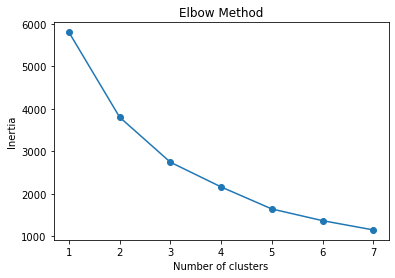

In [ ]:
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Cluster
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X)

# Get cluster centers (Coordinates of cluster centers)
centers = kmeans.cluster_centers_

# Get each point's cluster assignment (Labels of each point)
labels = kmeans.labels_ 

distances = np.linalg.norm(X - centers[labels], axis=1)  # euclidean distance

In [ ]:
small_cluster_data['K_cluster'] = labels
small_cluster_data

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Cluster_Signature,Cluster_ID,K_cluster
12,2019,9911456377,"[Cr, Dr, Dr, Cr]",2019-01-16,2019-01-17 12:29:36,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[-2708.0, 2708.0, 2724.52, -2724.52]",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0]",...,0.0,2708.00,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",8,1
48,2019,9911314077,"[Cr, Dr, Dr, Cr, Dr, Cr, Dr, Cr]",2019-01-03,2019-01-03 17:54:50,"[001, 002, 003, 004, 005, 006, 007, 008]","[Accounts Receivable Control Account, Third Pa...","[-42.06, 42.06, 129552.52, -129552.52, 0.05, -...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",...,0.0,42.11,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",6,1
97,2019,9911336036,"[Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr]",2019-01-02,2019-01-02 17:21:29,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Third Party Sales, Third Party Sales, Third P...","[-1.05, 1.05, -1.05, 1.05, -1.05, 1.05, -1.05,...",Billing Doc.Transfer,"[105.0, 0.0, 105.0, 0.0, 105.0, 0.0, 105.0, 0....",...,0.0,16.41,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,4
102,2019,9911336747,"[Cr, Dr, Cr, Dr]",2018-12-30,2018-12-31 14:10:39,"[001, 002, 003, 004]","[Third Party Sales, Third Party Sales, Third P...","[-23.96, 23.96, -17.32, 17.32]",Billing Doc.Transfer,"[4.0, 0.0, 4.0, 0.0]",...,0.0,41.28,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,4
108,2019,9911336795,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr]",2019-01-02,2019-01-03 11:49:09,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Intercompany Receivables Non Trade, Intercomp...","[5945.37, -2140.82, -2140.82, 2140.82, -3571.3...",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 1.0, 0.0...",...,0.0,0.00,None,None,None,None,None,"Cr_Cost of Goods Sold (COGS) - G\L Account, Cr...",49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156549,2019,9950835409,"[Cr, Dr, Dr, Cr]",2019-09-29,2019-09-30 13:15:10,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Sales Re...","[-2940.0, 2940.0, 41.0, -41.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 1.0, 0.0]",...,0.0,2981.00,[LAY EAN TEOH],[Siew Yen H'ng],WILL CALL,[RMACN SF:103462/DO:00891],PLEXCOM NETWORK SYSTEM SDN BHD,"Cr_Asset - Customer, Cr_Revenue - G\L Account,...",19,4
156554,2019,9950835436,"[Dr, Cr, Dr, Cr]",2019-09-26,2019-09-26 19:15:14,"[001, 002, 003, 004]","[Sales Returns & Allowance, Sales Returns & Al...","[1082.25, -1082.25, 1021.84, -1021.84]",Bill Doc.Tr - Cr Mem,"[1.0, 0.0, 0.0, 0.0]",...,0.0,1082.25,[JEAN CHAN],[Weng Kit Aaron Teoh],WILL CALL,[RMAC-85426-C1V5/SRV-148224],ALL IT HYPERMARKET SDN BHD,"Cr_Liability - G\L Account, Cr_Revenue - G\L A...",56,3
156564,2019,9950835456,"[Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, D...",2019-09-26,2019-09-26 16:15:15,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Sales Re...","[-16484.0, 12744.0, 12906.48, -12906.48, 3060....",Bill Doc.Tr - Cr Mem,"[0.0, 24.0, 0.0, 0.0, 24.0, 0.0, 0.0, 2.0, 0.0...",...,0.0,16484.00,[SIEW PENG LAU],[Kai Jian Wong],WILL CALL,[CN-8400086802],CTC GLOBAL SDN BHD,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",10,3
156643,2019,9950837135,"[Cr, Dr, Dr, Cr]",2019-09-27,2019-09-27 16:15:27,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Warranty...","[-954.0, 954.0, 636.0, -636.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0]",...,954.0,0.00,[LEE SAN LIM],[Yee Chang Yu],WILL CALL,[CN 9912997799],YCT COMPUTER CENTRE SDN BHD,"Cr_Asset - Customer, Cr_Other Costs - G\L Acco...",18,2


In [ ]:
sales_data['K_cluster'] = np.nan

# Assign the K_cluster values from df_labeled to matching indices in df_original
sales_data.loc[small_cluster_data.index, 'K_cluster'] = small_cluster_data['K_cluster']

sales_data['K_cluster'].notnull()

0         False
1         False
2         False
3         False
4         False
          ...  
156735    False
156736     True
156737    False
156738    False
156739    False
Name: K_cluster, Length: 156740, dtype: bool

In [ ]:
sales_data['K_cluster'].value_counts()

1.0    1574
3.0     819
2.0     672
4.0     519
0.0     411
Name: K_cluster, dtype: int64

In [ ]:
# Save results
table_name="cluster_21_clustered_separate"

sql_db.fn_create_new_table_from_df(table_name=table_name, df=sales_data, auto_data_type=True)
res=sql_db.fn_append_df_to_table(table_name=table_name, df=sales_data)
print(res)

# 8 min

True


### Dr_Cr and GL_AccType_AccountTypeDesc columns are merged <br>
Eg: Cr_Revenue - G\L Account, Dr_Asset - Customer

In [ ]:
X = small_cluster_data.copy()
if 'K_cluster' in X.columns:
    X = X.drop('K_cluster', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 12 to 156736
Data columns (total 79 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   FiscalYear                                  3995 non-null   int64         
 1   AccDocNo                                    3995 non-null   int64         
 2   Dr_Cr                                       3995 non-null   object        
 3   DateOfAccDocEntry                           3995 non-null   object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     3995 non-null   datetime64[ns]
 5   NoOfLineItemInAccDoc                        3995 non-null   object        
 6   GL_DESCRIPTION                              3995 non-null   object        
 7   Amt_localCurrencyFormatted                  3995 non-null   object        
 8   Document Type Description                   3995 non-null   object        
 9   Quant

In [ ]:
X[features] = (X[features] != 0).astype(int)
X[features].head(5)

,Cr_Asset - Asset,Cr_Asset - Customer,Cr_Asset - G\L Account,Cr_Asset - Material,Cr_Cost of Goods Sold (COGS) - G\L Account,Cr_Expense (6) - G\L Account,Cr_Liability - G\L Account,Cr_Liability - Vendor,Cr_Other Costs - G\L Account,Cr_Other Revenue - G\L Account,...,Dr_Asset - Customer,Dr_Asset - G\L Account,Dr_Asset - Material,Dr_Cost of Goods Sold (COGS) - G\L Account,Dr_Expense (6) - G\L Account,Dr_Liability - G\L Account,Dr_Liability - Vendor,Dr_Other Costs - G\L Account,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account
12,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
48,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
108,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


c:\Users\TEMP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


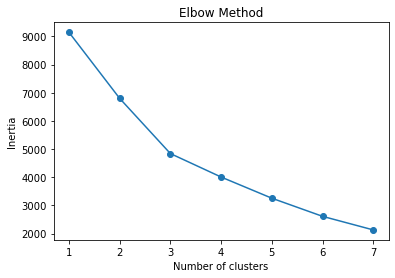

In [ ]:
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X[features])
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Cluster
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X[features])

# Get cluster centers (Coordinates of cluster centers)
centers = kmeans.cluster_centers_

# Get each point's cluster assignment (Labels of each point)
labels = kmeans.labels_ 

distances = np.linalg.norm(X[features] - centers[labels], axis=1)  # euclidean distance

In [ ]:
small_cluster_data['K_cluster'] = labels
small_cluster_data

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Cluster_Signature,Cluster_ID,K_cluster
12,2019,9911456377,"[Cr, Dr, Dr, Cr]",2019-01-16,2019-01-17 12:29:36,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[-2708.0, 2708.0, 2724.52, -2724.52]",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0]",...,0.0,2708.00,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",8,1
48,2019,9911314077,"[Cr, Dr, Dr, Cr, Dr, Cr, Dr, Cr]",2019-01-03,2019-01-03 17:54:50,"[001, 002, 003, 004, 005, 006, 007, 008]","[Accounts Receivable Control Account, Third Pa...","[-42.06, 42.06, 129552.52, -129552.52, 0.05, -...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",...,0.0,42.11,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",6,1
97,2019,9911336036,"[Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr]",2019-01-02,2019-01-02 17:21:29,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Third Party Sales, Third Party Sales, Third P...","[-1.05, 1.05, -1.05, 1.05, -1.05, 1.05, -1.05,...",Billing Doc.Transfer,"[105.0, 0.0, 105.0, 0.0, 105.0, 0.0, 105.0, 0....",...,0.0,16.41,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,1
102,2019,9911336747,"[Cr, Dr, Cr, Dr]",2018-12-30,2018-12-31 14:10:39,"[001, 002, 003, 004]","[Third Party Sales, Third Party Sales, Third P...","[-23.96, 23.96, -17.32, 17.32]",Billing Doc.Transfer,"[4.0, 0.0, 4.0, 0.0]",...,0.0,41.28,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,1
108,2019,9911336795,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr]",2019-01-02,2019-01-03 11:49:09,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Intercompany Receivables Non Trade, Intercomp...","[5945.37, -2140.82, -2140.82, 2140.82, -3571.3...",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 1.0, 0.0...",...,0.0,0.00,None,None,None,None,None,"Cr_Cost of Goods Sold (COGS) - G\L Account, Cr...",49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156549,2019,9950835409,"[Cr, Dr, Dr, Cr]",2019-09-29,2019-09-30 13:15:10,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Sales Re...","[-2940.0, 2940.0, 41.0, -41.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 1.0, 0.0]",...,0.0,2981.00,[LAY EAN TEOH],[Siew Yen H'ng],WILL CALL,[RMACN SF:103462/DO:00891],PLEXCOM NETWORK SYSTEM SDN BHD,"Cr_Asset - Customer, Cr_Revenue - G\L Account,...",19,1
156554,2019,9950835436,"[Dr, Cr, Dr, Cr]",2019-09-26,2019-09-26 19:15:14,"[001, 002, 003, 004]","[Sales Returns & Allowance, Sales Returns & Al...","[1082.25, -1082.25, 1021.84, -1021.84]",Bill Doc.Tr - Cr Mem,"[1.0, 0.0, 0.0, 0.0]",...,0.0,1082.25,[JEAN CHAN],[Weng Kit Aaron Teoh],WILL CALL,[RMAC-85426-C1V5/SRV-148224],ALL IT HYPERMARKET SDN BHD,"Cr_Liability - G\L Account, Cr_Revenue - G\L A...",56,1
156564,2019,9950835456,"[Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, D...",2019-09-26,2019-09-26 16:15:15,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Sales Re...","[-16484.0, 12744.0, 12906.48, -12906.48, 3060....",Bill Doc.Tr - Cr Mem,"[0.0, 24.0, 0.0, 0.0, 24.0, 0.0, 0.0, 2.0, 0.0...",...,0.0,16484.00,[SIEW PENG LAU],[Kai Jian Wong],WILL CALL,[CN-8400086802],CTC GLOBAL SDN BHD,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",10,1
156643,2019,9950837135,"[Cr, Dr, Dr, Cr]",2019-09-27,2019-09-27 16:15:27,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Warranty...","[-954.0, 954.0, 636.0, -636.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0]",...,954.0,0.00,[LEE SAN LIM],[Yee Chang Yu],WILL CALL,[CN 9912997799],YCT COMPUTER CENTRE SDN BHD,"Cr_Asset - Customer, Cr_Other Costs - G\L Acco...",18,1


In [ ]:
sales_data['K_cluster'] = np.nan

# Assign the K_cluster values from df_labeled to matching indices in df_original
sales_data.loc[small_cluster_data.index, 'K_cluster'] = small_cluster_data['K_cluster']

sales_data['K_cluster'].notnull()

0         False
1         False
2         False
3         False
4         False
          ...  
156735    False
156736     True
156737    False
156738    False
156739    False
Name: K_cluster, Length: 156740, dtype: bool

In [ ]:
sales_data['K_cluster'].value_counts()

0.0    1469
1.0    1426
2.0    1100
Name: K_cluster, dtype: int64

In [ ]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156740 entries, 0 to 156739
Data columns (total 80 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   FiscalYear                                  156740 non-null  int64         
 1   AccDocNo                                    156740 non-null  int64         
 2   Dr_Cr                                       156740 non-null  object        
 3   DateOfAccDocEntry                           156740 non-null  object        
 4   DateOfAccDocEntry_and_TimeOfEntry (MYT)     156740 non-null  datetime64[ns]
 5   NoOfLineItemInAccDoc                        156740 non-null  object        
 6   GL_DESCRIPTION                              156740 non-null  object        
 7   Amt_localCurrencyFormatted                  156740 non-null  object        
 8   Document Type Description                   156740 non-null  object       

In [ ]:
# Save results
table_name="cluster_21_clustered_merged"

sql_db.fn_create_new_table_from_df(table_name=table_name, df=sales_data, auto_data_type=True)
res=sql_db.fn_append_df_to_table(table_name=table_name, df=sales_data)
print(res)

# 9 mins

True


### GL_AccType_AccountTypeDesc column only 

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_desc = MultiLabelBinarizer()
desc_encoded = pd.DataFrame(
    mlb_desc.fit_transform(small_cluster_data['GL_AccType_AccountTypeDesc']),
    columns=mlb_desc.classes_,
    index=small_cluster_data.index
)

desc_encoded

,Asset - Customer,Asset - G\L Account,Cost of Goods Sold (COGS) - G\L Account,Liability - G\L Account,Other Costs - G\L Account,Other Revenue - G\L Account,Revenue - G\L Account
12,1,1,1,0,0,0,1
48,1,1,1,0,0,0,1
97,0,0,0,0,0,0,1
102,0,0,0,0,0,0,1
108,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...
156549,1,0,0,0,0,0,1
156554,0,0,1,1,0,0,1
156564,1,0,1,1,0,0,1
156643,1,0,0,1,1,1,0


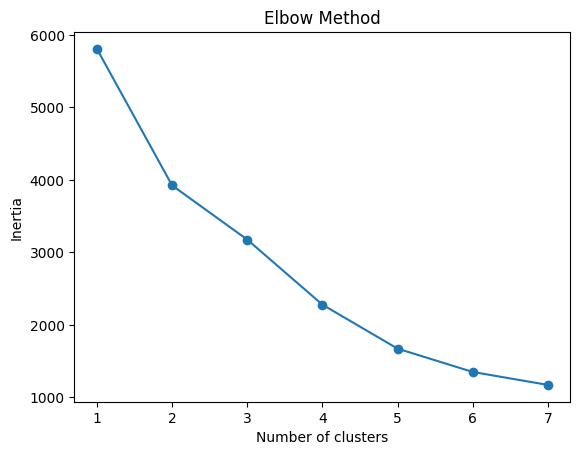

In [19]:
inertia = []
K = range(1, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(desc_encoded)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [21]:
# Cluster
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(desc_encoded)

# Get cluster centers (Coordinates of cluster centers)
centers = kmeans.cluster_centers_

# Get each point's cluster assignment (Labels of each point)
labels = kmeans.labels_ 

distances = np.linalg.norm(desc_encoded - centers[labels], axis=1)  # euclidean distance

In [22]:
small_cluster_data['K_cluster'] = labels
small_cluster_data

,FiscalYear,AccDocNo,Dr_Cr,DateOfAccDocEntry,DateOfAccDocEntry_and_TimeOfEntry (MYT),NoOfLineItemInAccDoc,GL_DESCRIPTION,Amt_localCurrencyFormatted,Document Type Description,Quantity,...,Dr_Other Revenue - G\L Account,Dr_Revenue - G\L Account,IS Rep,OS Rep,Carrier Key Desc,Customer PO Number,Sold-To Id,Cluster_Signature,Cluster_ID,K_cluster
12,2019,9911456377,"[Cr, Dr, Dr, Cr]",2019-01-16,2019-01-17 12:29:36,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Third Pa...","[-2708.0, 2708.0, 2724.52, -2724.52]",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0]",...,0.0,2708.00,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",8,0
48,2019,9911314077,"[Cr, Dr, Dr, Cr, Dr, Cr, Dr, Cr]",2019-01-03,2019-01-03 17:54:50,"[001, 002, 003, 004, 005, 006, 007, 008]","[Accounts Receivable Control Account, Third Pa...","[-42.06, 42.06, 129552.52, -129552.52, 0.05, -...",Billing Doc.Transfer,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",...,0.0,42.11,None,None,None,None,None,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",6,0
97,2019,9911336036,"[Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr, Cr, Dr]",2019-01-02,2019-01-02 17:21:29,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Third Party Sales, Third Party Sales, Third P...","[-1.05, 1.05, -1.05, 1.05, -1.05, 1.05, -1.05,...",Billing Doc.Transfer,"[105.0, 0.0, 105.0, 0.0, 105.0, 0.0, 105.0, 0....",...,0.0,16.41,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,4
102,2019,9911336747,"[Cr, Dr, Cr, Dr]",2018-12-30,2018-12-31 14:10:39,"[001, 002, 003, 004]","[Third Party Sales, Third Party Sales, Third P...","[-23.96, 23.96, -17.32, 17.32]",Billing Doc.Transfer,"[4.0, 0.0, 4.0, 0.0]",...,0.0,41.28,None,None,None,None,None,"Cr_Revenue - G\L Account, Dr_Revenue - G\L Acc...",66,4
108,2019,9911336795,"[Dr, Cr, Cr, Dr, Cr, Cr, Dr, Cr, Cr, Dr]",2019-01-02,2019-01-03 11:49:09,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Intercompany Receivables Non Trade, Intercomp...","[5945.37, -2140.82, -2140.82, 2140.82, -3571.3...",Billing Doc.Transfer,"[0.0, 10.0, 0.0, 0.0, 10.0, 0.0, 0.0, 1.0, 0.0...",...,0.0,0.00,None,None,None,None,None,"Cr_Cost of Goods Sold (COGS) - G\L Account, Cr...",49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156549,2019,9950835409,"[Cr, Dr, Dr, Cr]",2019-09-29,2019-09-30 13:15:10,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Sales Re...","[-2940.0, 2940.0, 41.0, -41.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 1.0, 0.0]",...,0.0,2981.00,[LAY EAN TEOH],[Siew Yen H'ng],WILL CALL,[RMACN SF:103462/DO:00891],PLEXCOM NETWORK SYSTEM SDN BHD,"Cr_Asset - Customer, Cr_Revenue - G\L Account,...",19,1
156554,2019,9950835436,"[Dr, Cr, Dr, Cr]",2019-09-26,2019-09-26 19:15:14,"[001, 002, 003, 004]","[Sales Returns & Allowance, Sales Returns & Al...","[1082.25, -1082.25, 1021.84, -1021.84]",Bill Doc.Tr - Cr Mem,"[1.0, 0.0, 0.0, 0.0]",...,0.0,1082.25,[JEAN CHAN],[Weng Kit Aaron Teoh],WILL CALL,[RMAC-85426-C1V5/SRV-148224],ALL IT HYPERMARKET SDN BHD,"Cr_Liability - G\L Account, Cr_Revenue - G\L A...",56,4
156564,2019,9950835456,"[Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, Dr, Cr, Dr, D...",2019-09-26,2019-09-26 16:15:15,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ...","[Accounts Receivable Control Account, Sales Re...","[-16484.0, 12744.0, 12906.48, -12906.48, 3060....",Bill Doc.Tr - Cr Mem,"[0.0, 24.0, 0.0, 0.0, 24.0, 0.0, 0.0, 2.0, 0.0...",...,0.0,16484.00,[SIEW PENG LAU],[Kai Jian Wong],WILL CALL,[CN-8400086802],CTC GLOBAL SDN BHD,"Cr_Asset - Customer, Cr_Cost of Goods Sold (CO...",10,4
156643,2019,9950837135,"[Cr, Dr, Dr, Cr]",2019-09-27,2019-09-27 16:15:27,"[001, 002, 003, 004]","[Accounts Receivable Control Account, Warranty...","[-954.0, 954.0, 636.0, -636.0]",Bill Doc.Tr - Cr Mem,"[0.0, 1.0, 0.0, 0.0]",...,954.0,0.00,[LEE SAN LIM],[Yee Chang Yu],WILL CALL,[CN 9912997799],YCT COMPUTER CENTRE SDN BHD,"Cr_Asset - Customer, Cr_Other Costs - G\L Acco...",18,2


In [23]:
sales_data['K_cluster'] = np.nan

# Assign the K_cluster values from df_labeled to matching indices in df_original
sales_data.loc[small_cluster_data.index, 'K_cluster'] = small_cluster_data['K_cluster']

sales_data['K_cluster'].notnull()

0         False
1         False
2         False
3         False
4         False
          ...  
156735    False
156736     True
156737    False
156738    False
156739    False
Name: K_cluster, Length: 156740, dtype: bool

In [24]:
sales_data['K_cluster'].value_counts()

K_cluster
0.0    1574
4.0    1160
2.0     628
3.0     411
1.0     222
Name: count, dtype: int64

In [26]:
# Save results
table_name="cluster_23_clustered"
try:
    sql_db.fn_create_new_table_from_df(table_name=table_name, df=sales_data, auto_data_type=True)
    res=sql_db.fn_append_df_to_table(table_name=table_name, df=sales_data)
    print(res)
except:
    sales_data.to_csv(rf'd:\victoriaquek\JE ML 2025\{table_name}')
# 8 min

### SQL Profiling

In [ ]:
SELECT 
    K_cluster,
    Cluster_Signature,
	Cluster_ID,
    COUNT(*) AS count_in_cluster
FROM 
    cluster_22_clustered
GROUP BY 
    K_cluster, Cluster_Signature, Cluster_ID
ORDER BY 
    K_cluster, Cluster_ID;

## Numeric features

In [ ]:
# cluster_info = sales_data['Cluster_ID'].value_counts()
# small_cluster_ids = cluster_info[cluster_info < 1000].index.tolist()
# print(small_cluster_ids)

In [ ]:
def compute_magnitude(amounts):
    pos_mag = sum(x for x in amounts if x > 0)
    neg_mag = sum(abs(x) for x in amounts if x < 0)

    if round(pos_mag,4) == round(neg_mag,4):
        return round(pos_mag,4)
    else:
        return [pos_mag, neg_mag]
        # return max(pos_mag, neg_mag)

def new_cols(df):
    df['amount_magnitude'] = df['Amt_localCurrencyFormatted'].apply(compute_magnitude)
    df['sum_trailingzeroes'] = df['Amt_DocCurrency_NoOfTrailingZeroes'].apply(sum)
    df['num_entries'] = df['Amt_localCurrencyFormatted'].apply(len)
    return df

new_cols(small_cluster_data)

In [ ]:
non_features = [
'Dr_Cr', 
'AccDocNo',
'FiscalYear',
'DateOfAccDocEntry',
'NoOfLineItemInAccDoc',
# 'IsDocReversalOrReversedDoc'
]

# Get boolean cols
bool_cols = small_cluster_data.select_dtypes(include='bool').columns.to_list()
print(bool_cols)

# Convert bool cols to int
small_cluster_data[bool_cols] = small_cluster_data[bool_cols].astype(int)

# Get numerical feature columns
def get_num_cols(df):
    numerical_cols = df.select_dtypes(include='number').columns.tolist()

    numerical_cols = [item for item in numerical_cols if item not in non_features]

    return numerical_cols

num_cols = get_num_cols(small_cluster_data)
print(len(num_cols))
print(num_cols)

In [ ]:
# df_numeric = grouped_data[num_cols]
df_numeric = small_cluster_data[num_cols]
# grouped_data.head(5)
df_numeric.head(5)
print(df_numeric.columns)
print(len(df_numeric.columns))

In [ ]:
inertia = []
K = range(1, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_numeric)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Cluster
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(df_numeric)

# Get cluster centers (Coordinates of cluster centers)
centers = kmeans.cluster_centers_

# Get each point's cluster assignment (Labels of each point)
labels = kmeans.labels_ 

distances = np.linalg.norm(df_numeric - centers[labels], axis=1)

### Functions

In [ ]:
# Make a dataframe of how many points and outliers are in each cluster
def count_points_and_outliers_df(df, k, thresholds):
    summary = []
    is_per_cluster_threshold = isinstance(thresholds, (list, np.ndarray))

    for cluster in range(k):
        cluster_mask = (df['cluster'] == cluster)
        total = np.sum(cluster_mask)
        outliers = np.sum(df['outlier'] & cluster_mask)

        row = ({
            'Cluster': cluster,  
            'Total_Points': total,
            'Outliers': outliers
        })

        if thresholds is not None:
            if is_per_cluster_threshold:
                row['Threshold'] = thresholds[cluster]
            else:
                row['Threshold'] = thresholds

        summary.append(row)

    return pd.DataFrame(summary)

In [ ]:
# Define different threshold strategies as functions
def threshold_strategies(X, distances, labels):
    return {
        '2sd': lambda distances: distances.mean() + 2 * distances.std(),
        '99': lambda distances: np.percentile(distances, 99),
    }

In [ ]:
# Function to run global outlier detection for different thresholds
def global_outlier_c(df_base, df_used, labels, distances, k, sql_db, table_base_name):
    
    strategy_funcs = threshold_strategies(df_used, distances, labels)

    for strategy_name, threshold_func in strategy_funcs.items():
        print(f"\nRunning outlier detection with threshold strategy: {strategy_name}")
        
        # Compute threshold
        threshold = threshold_func(distances)
        print(f"Threshold value: {threshold}")

        # Identify outliers
        outliers = distances > threshold
        print(f"Number of outliers: {np.sum(outliers)}")

        # Prepare DataFrame
        df = df_base.copy()

        # Remove existing columns if they exist
        for col in ['outlier', 'cluster']:
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)

        # Add new columns
        df['cluster'] = labels
        df['outlier'] = outliers

        # Save to SQL
        table_name = f"{table_base_name}_{strategy_name}_clustered"
        print(f"\nSaving clustered data to table: {table_name}")

        # Create new table and append data
        sql_db.fn_create_new_table_from_df(table_name=table_name, df=df, auto_data_type=True)
        res = sql_db.fn_append_df_to_table(table_name=table_name, df=df)
        print("Append result:", res)

        # Cluster profile
        c_prof = count_points_and_outliers_df(df, k, threshold)
        print("\nCluster Profile:")
        print(c_prof)

        # Save cluster profile
        profile_table_name = table_name.replace("clustered", "cluster_profile")
        print(f"\nSaving cluster profile to table: {profile_table_name}")

        sql_db.fn_create_new_table_from_df(table_name=profile_table_name, df=c_prof, auto_data_type=True)
        res = sql_db.fn_append_df_to_table(table_name=profile_table_name, df=c_prof)
        print("Append result:", res)

In [ ]:
# Function to run cluster outlier detection for different thresholds
def cluster_outlier_c(df_base, df_used, labels, distances, k, sql_db, table_base_name):
    
    strategy_funcs = threshold_strategies(df_used, distances, labels)

    for strategy_name, threshold_func in strategy_funcs.items():
        print(f"\nRunning outlier detection with threshold strategy: {strategy_name}")
    
        # Initialize outliers array
        outliers = np.zeros(len(df_base), dtype=bool)

        # Prepare DataFrame
        df = df_base.copy()

        # Remove existing columns if they exist
        for col in ['outlier', 'cluster']:
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
        
        thresholds = []
        for cluster in range(kmeans.n_clusters):                 # Goes through each cluster
            cluster_distances = distances[labels == cluster]     # Get distance of each point from cluster centroid
            cluster_indices = np.where(labels == cluster)[0]     # Get data points belonging to current cluster

            # Define threshold for this cluster
            thresh = threshold_func(cluster_distances)
            print(f"Cluster {cluster} - Threshold: {thresh}")
            thresholds.append(thresh)

            # Mark points exceeding threshold as outliers
            cluster_outliers = cluster_distances > thresh
            outliers[cluster_indices[cluster_outliers]] = True

        # Add new columns
        df['cluster'] = labels
        df['outlier'] = outliers

        num_outliers = df['outlier'].sum()
        print(f"Number of outliers: {num_outliers}")

        # Save to SQL
        table_name = f"{table_base_name}_{strategy_name}_clustered"
        print(f"\nSaving clustered data to table: {table_name}")

        # Create new table and append data
        sql_db.fn_create_new_table_from_df(table_name=table_name, df=df, auto_data_type=True)
        res = sql_db.fn_append_df_to_table(table_name=table_name, df=df)
        print("Append result:", res)

        # Cluster profile
        c_prof = count_points_and_outliers_df(df, k, thresholds)
        print("\nCluster Profile:")
        print(c_prof)

        # Save cluster profile
        profile_table_name = table_name.replace("clustered", "cluster_profile")
        print(f"\nSaving cluster profile to table: {profile_table_name}")

        sql_db.fn_create_new_table_from_df(table_name=profile_table_name, df=c_prof, auto_data_type=True)
        res = sql_db.fn_append_df_to_table(table_name=profile_table_name, df=c_prof)
        print("Append result:", res)

### Clustering

In [ ]:
global_outlier_c(
    df_base=small_cluster_data,
    df_used=df_numeric,
    labels=kmeans.labels_,
    distances=distances,
    k=2,
    sql_db=sql_db,
    table_base_name="cluster_21_global"
)

In [ ]:
# cluster_outlier_c(df_base, df_used, labels, distances, k, sql_db, table_base_name)
cluster_outlier_c(
    df_base=small_cluster_data,
    df_used=df_numeric,
    labels=kmeans.labels_,
    distances=distances,
    k=2,
    sql_db=sql_db,
    table_base_name="cluster_21_cluster"
)

### Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# On new results
# Train a classifier to predict clusters (surrogate model)
df = df_numeric.copy()
df['cluster'] = kmeans.fit_predict(df)

# Train surrogate model
X = df.drop('cluster', axis=1)
y = df['cluster']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# Extract feature importances
importances = clf.feature_importances_
# feature_names = df.columns[:-1]  # exclude 'cluster' column
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances,
    'Importance (%)': importances * 100
})
# .sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance_df.sort_values(by='Importance', ascending=False)

# K means on each manual cluster

## Functions

In [ ]:
def get_distances_to_centroids(X, labels):
    unique_labels = np.unique(labels)
    centroids = []

    # Calculate centroids
    for label in unique_labels:
        mask = (labels == label)
        centroid = X[mask].mean(axis=0)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Pairwise distance from each point to its cluster centroid
    distances = cdist(X, centroids, metric='euclidean')
    closest_centroid_distances = distances[np.arange(len(labels)), labels]

    return closest_centroid_distances

In [ ]:
def detect_outliers(X, labels, strategy_name='2sd'):
    unique_labels = np.unique(labels)
    is_outlier = np.zeros(len(labels), dtype=bool)

    for label in unique_labels:
        mask = (labels == label)
        cluster_distances = X[mask]  # Distances for entries in this cluster

        if len(cluster_distances) <= 1:
            continue  # Skip small clusters

        # Get threshold function dynamically
        threshold_func = threshold_strategies(None, cluster_distances, None)[strategy_name]
        threshold = threshold_func(cluster_distances)

        # Mark points exceeding threshold as outliers
        is_outlier[mask] = cluster_distances > threshold

    return is_outlier

In [ ]:
# Assume df is your DataFrame and feature_columns are selected
feature_columns = ['IND_MonthEnd', 'IND_QuarterEnd', 'IND_YearEnd', 'IND_Weekend', 'IND_PublicHol', 'IND_OutsideWorkHours',
       'labelled_Document Type Description', 'labelled_TransactionCode', 'labelled_Username Type', 'labelled_Carrier Key Desc']
X = sales_data[feature_columns].values
labels = sales_data['Cluster_ID'].values  # From earlier clustering

# Step 1: Get distances to centroids
distances = get_distances_to_centroids(X, labels)

# Add distances back to DataFrame
sales_data['Distance_to_Centroid'] = distances

# Step 2: Detect outliers using '2sd' strategy
sales_data['Is_Outlier'] = detect_outliers(distances, labels, strategy_name='2sd')

# Show outliers
outliers = sales_data[sales_data['Is_Outlier']]
outliers[['AccDocNo', 'Cluster_ID', 'Distance_to_Centroid', 'Is_Outlier']]

In [ ]:
# Use different strategy per cluster
strategy_map = {0: '2sd', 1: '99', 2: '2sd'}  # e.g., cluster 1 uses 99th percentile

def detect_outliers_with_strategy_map(X, labels, strategy_map):
    unique_labels = np.unique(labels)
    is_outlier = np.zeros(len(labels), dtype=bool)

    for label in unique_labels:
        mask = (labels == label)
        cluster_distances = X[mask]

        if len(cluster_distances) <= 1:
            continue

        strategy_name = strategy_map.get(label, '2sd')  # Default to '2sd'
        threshold = threshold_strategies(None, cluster_distances, None)[strategy_name](cluster_distances)
        is_outlier[mask] = cluster_distances > threshold

    return is_outlier